In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import heartpy as hp
import pandas as pd
import numpy as np 
import pywt as pw
import openpyxl
import pickle
import tsfel
import json

# Functions

In [2]:
# TODO Banpass Buttwe
num_of_participants = 23
num_of_clips = 18

#In Hz:
cutoff = [0.5, 45]
sample_rate = 256.0
order = 3
filtertype ='bandpass'
def data_filter (data):
    # Separate data by channel
    for participant in data.keys():
        print("Starting " + participant)
        for clip_num in range(0, num_of_clips):
            # Filter both channels from baseline
            CH1 = [row[0] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH1_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            CH2 = [row[1] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH2_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            s_clip = "clip " + str(clip_num+1) 

            data[participant]['ECG'][s_clip] = {}
            data[participant]['ECG'][s_clip]['CH1'] = {}
            data[participant]['ECG'][s_clip]['CH1']['baseline'] = CH1_filtered.tolist()
            data[participant]['ECG'][s_clip]['CH2'] = {}
            data[participant]['ECG'][s_clip]['CH2']['baseline'] = CH2_filtered.tolist()

            
            # Filter both channels from stimuli
            CH1 = [row[0] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH1_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            CH2 = [row[1] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH2_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            data[participant]['ECG'][s_clip]['CH1']['stimuli'] = CH1_filtered.tolist()
            data[participant]['ECG'][s_clip]['CH2']['stimuli'] = CH2_filtered.tolist()

            data[participant]['ECG'][s_clip]['ScoreValence'] = data[participant]['ScoreValence'][clip_num]
            data[participant]['ECG'][s_clip]['ScoreArousal'] = data[participant]['ScoreArousal'][clip_num]
            data[participant]['ECG'][s_clip]['ScoreDominance'] = data[participant]['ScoreDominance'][clip_num]
            
            print("Done filtering raw for " + participant + " at clip#" + str(clip_num+1) , end="\r", flush=True)
        data[participant]['ECG'].pop('stimuli')
        data[participant]['ECG'].pop('baseline')

        data[participant].pop('ScoreValence')
        data[participant].pop('ScoreArousal')
        data[participant].pop('ScoreDominance')
    
    print("All done.... Highpass filter applied, cutoff: [" + str(cutoff[0]) + "," + str(cutoff[1]) + "]Hz")
    return data
            
            
### Function to display graph
def show_graph(participant, clip, dtype, range_min = 0, range_max = -1):
    plt.plot(filtered_data[participant]['ECG'][dtype][clip][range_min:range_max])
    plt.ylabel("mV")
    plt.xlabel("Sample #")
    graph_title = participant + "  clip#" + str(clip) + " " + dtype + " data range: " + str(range_min) + " => " + str(range_max)
    plt.title(graph_title)

### Function to split channels
def chan_split(filtered_data, participant, clip, dtype):
    ch1 = [row[0] for row in filtered_data[participant]['ECG'][dtype][clip]]
    ch2 = [row[1] for row in filtered_data[participant]['ECG'][dtype][clip]]
    
    return ch1, ch2


### Function to plot Heard Rate Signal Peak Detection
def peak_detection(participant, clip, dtype, ch = 1, range_min = 0, range_max = -1):
    
    p1_c1_ch1, p1_c1_ch2 =(chan_split(participant, clip, dtype))
    wd1 = hp.process(p1_c1_ch1[range_min:range_max], 256)
    wd2 = hp.process(p1_c1_ch1[range_min:range_max], 256)
    if ch == 1:
        hp.plotter(wd1[0], wd1[1])
    else:
        hp.plotter(wd2[0], wd2[1])
            

# Load & Process RAW Data, then create and save processed data to .pkl

Starting participant_1
Starting participant_10participant_1 at clip#18
Starting participant_11participant_10 at clip#18
Starting participant_12participant_11 at clip#18
Starting participant_13participant_12 at clip#18
Starting participant_14participant_13 at clip#18
Starting participant_15participant_14 at clip#18
Starting participant_16participant_15 at clip#18
Starting participant_17participant_16 at clip#18
Starting participant_18participant_17 at clip#18
Starting participant_19participant_18 at clip#18
Starting participant_2 participant_19 at clip#18
Starting participant_20participant_2 at clip#18
Starting participant_21participant_20 at clip#18
Starting participant_22participant_21 at clip#18
Starting participant_23participant_22 at clip#18
Starting participant_3 participant_23 at clip#18
Starting participant_4 participant_3 at clip#18
Starting participant_5 participant_4 at clip#18
Starting participant_6 participant_5 at clip#18
Starting participant_7 participant_6 at clip#18
Sta

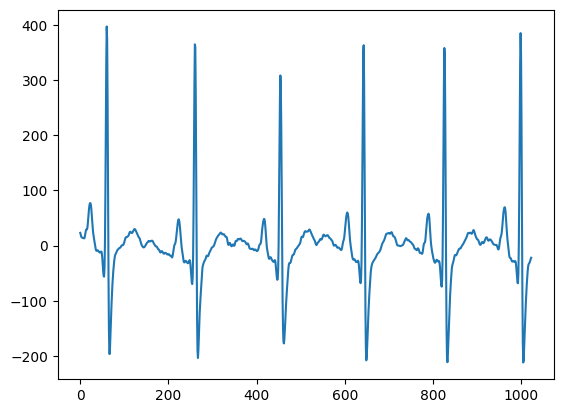

In [3]:
raw_data = {}
load_raw_from = '../data_set_raw_ECG/raw_data_dict.pkl'
dump_to = '../data_set_raw_ECG/processed_data_dict.pkl'

with open(load_raw_from, 'rb') as f:
    raw_data = pickle.load(f)

filtered_data = data_filter(raw_data)

with open(dump_to, 'wb') as f:
    pickle.dump(filtered_data, f)
    print("Dumped proccesed data for " , str(num_of_participants), " participants and ", str(num_of_clips), " ", dump_to)

plt.plot(raw_data['participant_1']['ECG']['clip 1']['CH1']['stimuli'][0:1024])

del raw_data
del filtered_data

# Load Filtered Data

In [4]:
data = {}
load_processed_from = '../data_set_raw_ECG/processed_data_dict.pkl'
with open(load_processed_from, 'rb') as f:
    data = pickle.load(f)

In [5]:
data['participant_1']['ECG']['clip 1'].keys()
len(data['participant_1']['ECG']['clip 1']['CH1']['stimuli'])


50944

# Extract Time Domain

In [6]:
def extract_time_domain(processed_data):
    features = {}
    cfg = tsfel.get_features_by_domain()
    for participant in processed_data:
        features[participant] = {}
        for clip in processed_data[participant]['ECG']:
            mod = 256 % data[participant]['ECG'][clip]['CH1']['stimuli']
            sample_size = len(data['participant_1']['ECG']['clip 1']['CH1']['stimuli']) 
            exclude = ((sample_size-(mod*256))/2)
            i = 0
            while i < sample_size :
                features[participant][clip] = {}
                features[participant][str(clip)]['CH1'] = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'][i:i+2560])
                features[participant][str(clip)]['CH2'] = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH2']['stimuli'][i:i+2560])
                
                features[participant][str(clip)]['ScoreValence'] = data[participant]['ScoreValence']
                features[participant][str(clip)]['ScoreArousal'] = data[participant]['ScoreArousal']
                features[participant][str(clip)]['ScoreDominance'] = data[participant]['ScoreDominance']
                
                i += 2560
            
            print("Done with time features for participant ", participant, " clip ", clip)
    return features

import warnings
warnings.filterwarnings("ignore")

def extract_time_domain_as_pd_df(processed_data):
    combined_data = pd.DataFrame()
    cfg = tsfel.get_features_by_domain()
    for participant in processed_data:
        for clip in processed_data[participant]['ECG']:
            data_size = len(processed_data[participant]['ECG'][clip]['CH1']['stimuli'])
            for_iterations = 2560 % data_size
            for i in range(0, data_size, 2560):
                print("Processing " + participant + " " + clip + " window:" + str(int(i/2560)) + "/" + str(int(data_size/2560)) + "          ", end="\r", flush=True)
                features_df_ch1 = pd.DataFrame()
                features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'][i:i+2560], verbose=False)
                features_df_ch1['ScoreValence'] = data[participant]['ECG'][clip]['ScoreValence']
                features_df_ch1['ScoreArousal'] = data[participant]['ECG'][clip]['ScoreArousal']
                features_df_ch1['ScoreDominance'] = data[participant]['ECG'][clip]['ScoreDominance']
            
                combined_data = pd.concat([combined_data, features_df_ch1], ignore_index=True)
            
                # print("Done with time features for participant ", participant, " clip ", clip)
    return combined_data



#def extract_time_domain_as_pd_df(processed_data):
#    combined_data = pd.DataFrame()
#    cfg = tsfel.get_features_by_domain()
#    for participant in processed_data:
#        for clip in processed_data[participant]['ECG']:
#            # TODO Create multiple rows with each video, split 
#            features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])
#            # features_df_ch2 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH2']['stimuli'])
#            
#            features_df_ch1['ScoreValence'] = data[participant]['ECG'][clip]['ScoreValence']
#            features_df_ch1['ScoreArousal'] = data[participant]['ECG'][clip]['ScoreArousal']
#            features_df_ch1['ScoreDominance'] = data[participant]['ECG'][clip]['ScoreDominance']#

    #         # features_df_ch2['ScoreValence'] = data[participant]['ECG'][clip]['ScoreValence']
    #         # features_df_ch2['ScoreArousal'] = data[participant]['ECG'][clip]['ScoreArousal']
    #         # features_df_ch2['ScoreDominance'] = data[participant]['ECG'][clip]['ScoreDominance']
            
    #         combined_data = pd.concat([combined_data, features_df_ch1], ignore_index=False) #combined_data.append(features_df_ch1, ignore_index=false)
    #         #combined_data = combined_data.append(features_df_ch2, ignore_index=false)
            
    #         print("Done with time features for participant ", participant, " clip ", clip)
    # return combined_data


In [ ]:
# Save to dict to .pkl
# time_domain_features = extract_time_domain(data)

# dump_to = '../features/time_domain_all_dict.pkl'
# with open(dump_to, 'wb') as f:
#     pickle.dump(time_domain_features, f)
# del time_domain_features

In [7]:
# Save pandas df to .pkl

time_domain_df = extract_time_domain_as_pd_df(data)

dump_to = '../features/time_domain_df.pkl'
time_domain_df.to_pickle(dump_to)
time_domain_df.to_excel('../features/time_domain_df.xlsx')

del time_domain_df

# Train the Model using sklearn

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd

In [23]:
# Load data
features_df = pd.read_pickle('../features/time_domain_df.pkl')
features_df.fillna(0, inplace=True)

# Split Data into X and Y
X = features_df.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = features_df[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

# Train the SVM
svm_model = SVC(kernel='linear')  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)

Accuracy for Valence: 0.39702517162471396
Accuracy for Arousal: 0.4548054919908467
Accuracy for Dominance: 0.4490846681922197


In [18]:
X = features_df.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = features_df[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

# Train the SVM
svm_model = SVC(kernel='rbf')  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)

Accuracy for Valence: 0.4279176201372998
Accuracy for Arousal: 0.4919908466819222
Accuracy for Dominance: 0.4994279176201373


In [19]:
X = features_df.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = features_df[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

# Train the SVM
svm_model = SVC(kernel='poly')  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)

Accuracy for Valence: 0.37299771167048057
Accuracy for Arousal: 0.4387871853546911
Accuracy for Dominance: 0.4502288329519451


In [ ]:
len(features_df)

In [21]:
#as per the correlation matrix the features seems to be correlated so applying PCA 
from sklearn.decomposition import PCA

# Load data
features_df = pd.read_pickle('../features/time_domain_df.pkl')
features_df.fillna(0, inplace=True)

# Split Data into X and Y
X = features_df.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = features_df[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

pca = PCA(0.95) #PCA with 95% variance

X_train = pca.fit_transform(X_train) #PCA on train data
X_test = pca.transform(X_test)#PCA on test data

print(pca.explained_variance_ratio_)

# Train the SVM
svm_model = SVC(kernel='rbf')  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)


[0.2006622  0.15887182 0.11292323 0.04923528 0.04525589 0.04036887
 0.02623952 0.02376189 0.01811221 0.0162168  0.01417675 0.01120414
 0.00904894 0.00841714 0.00759776 0.00678051 0.00623158 0.00586231
 0.00561471 0.00470877 0.00441023 0.00412862 0.00396995 0.00374052
 0.0035311  0.0033563  0.00327766 0.00314684 0.00309633 0.00306774
 0.00302261 0.00284203 0.00281157 0.00271091 0.00268457 0.00263983
 0.00257324 0.00256653 0.00245757 0.00242968 0.00239469 0.00233648
 0.00226236 0.00219505 0.00217826 0.00215003 0.00211537 0.0020973
 0.00207766 0.00204078 0.0020079  0.00195363 0.00194282 0.00190832
 0.00188538 0.00185095 0.0018151  0.00179833 0.00176972 0.00173656
 0.0017141  0.00170879 0.00168905 0.00166452 0.00165343 0.00164232
 0.0016145  0.00160255 0.00158139 0.00155947 0.00154637 0.001533
 0.0015067  0.0014841  0.00147577 0.00145466 0.00144722 0.0014379
 0.00141431 0.0014103  0.00139428 0.00138542 0.00137424 0.00135684
 0.00133559 0.00131245 0.00129825 0.00128363 0.00127664 0.00126987

In [24]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import svm
# from sklearn import metrics

# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf', 'poly']} 
  
# grid = GridSearchCV(multi_target_svm, param_grid, refit = True, verbose = 3) #Grid model definition
  
# grid.fit(X_train, Y_train) #fit the grid mode